# EnergyFaultDetector @ District Heatin

This notebook shows how to apply the EnergyFaultDetector on the PreDist dataset (available on [zenodo](https://doi.org/10.5281/zenodo.17522254)) and how to reproduce results from the accompanying paper (preprint available on [arXiv](https://doi.org/10.48550/arXiv.2511.14791)).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, precision_score, recall_score, ConfusionMatrixDisplay

from energy_fault_detector.evaluation import PreDistDataset
from energy_fault_detector import FaultDetector, Config
from energy_fault_detector.utils.visualisation import plot_score_with_threshold, plot_reconstruction
from energy_fault_detector.utils.analysis import create_events

from predist_utils import train_or_get_model, find_optimal_threshold, get_arcana_importances

### Load dataset

In [2]:
dataset = PreDistDataset('./predist_data', download_dataset=False)
# Check events for manufacturer 1
dataset.events[1]

,substation ID,Report date,Problem EN,Event description EN,Possible anomaly start,Possible anomaly end,Training start,Training end,efd_possible,Fault label,Monitoring potential,Event type,Event end,Event start
Event ID,,,,,,,,,,,,,,
1,10,2014-05-04 14:44:00,no DHW,No hot water. Actuator (DHW system) replaced.,2014-05-03 16:00:00,2014-05-05 04:00:00,2012-03-28 09:00:00,2014-04-20 14:44:00,True,Motorised control valve (primary side): Actuat...,3.4,anomaly,2014-05-04 14:44:00,NaT
3,12,2015-12-01 10:56:00,no heat,Control parameters updated.,2015-11-29 12:00:00,2015-12-02 10:56:00,2015-03-01 00:00:00,2015-11-17 10:56:00,True,Control unit: Incorrect parameterisation,4,anomaly,2015-12-01 10:56:00,NaT
5,11,2018-11-23 08:30:00,no heat,Pump settings updated.,NaT,2018-11-26 09:56:59,2015-02-20 14:00:00,2018-11-09 08:30:00,True,Failure of the heating circuit pump,3.8,anomaly,2018-11-23 08:30:00,NaT
6,21,2016-12-06 13:12:00,not enough heat,The heaters are not getting warm enough. Suppl...,NaT,2016-12-07 13:12:00,2015-11-30 09:00:00,2016-11-22 13:12:00,True,Control unit: Incorrect parameterisation,4,anomaly,2016-12-06 13:12:00,NaT
7,26,2020-06-13 10:38:00,no DHW,The needle valve was closed. Readjusted.,2020-06-12 12:00:00,2020-06-14 10:38:00,2018-10-18 13:00:00,2020-05-30 10:38:00,True,Incorrect setting of the differential pressure...,3.1,anomaly,2020-06-13 10:38:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,5,NaT,NaN,NaN,NaT,NaT,2016-02-29 00:00:00,2018-02-28 00:00:00,NaN,NaN,NaN,normal,2018-03-07 00:00:00,2018-02-28
59,22,NaT,NaN,NaN,NaT,NaT,2018-06-21 10:00:00,2019-01-31 00:00:00,NaN,NaN,NaN,normal,2019-02-07 00:00:00,2019-01-31
61,14,NaT,NaN,NaN,NaT,NaT,2017-12-04 00:00:00,2019-12-05 00:00:00,NaN,NaN,NaN,normal,2019-12-12 00:00:00,2019-12-05


### Create or load models (uses optimized configs)

In [3]:
model_configs = {
    1: {
        'config_files': {
            'default_ae': './configs/m1_default_ae.yaml',
            'cond_ae': './configs/m1_cond_ae.yaml',
            'doy_ae': './configs/m1_doy_ae.yaml'
        },
        'bottleneck': 0.65
    },
    2: {
        'config_files': {
            'default_ae': './configs/m2_default_ae.yaml',
            'cond_ae': './configs/m2_cond_ae.yaml',
            'doy_ae': './configs/m2_doy_ae.yaml'
        },
        'bottleneck': 0.25
    }
}

# Model file exists, load the model
load_from_file = True

In [4]:
# Create or load model, predict and collect results for all events
from joblib import Parallel, delayed


# Select which dataset(s) and model configs to test:
manufacturers = [1, 2]  # [1, 2]
models = ['default_ae', 'cond_ae']  # ['default_ae', 'cond_ae', 'doy_ae']

results = {}
for manufacturer in manufacturers:
    results[manufacturer] = {}
    for config_name, config_file in model_configs[manufacturer]['config_files'].items():
        if config_name not in models:
            continue

        conf = Config(config_file)
        dp_params = conf.config_dict['train']['data_preprocessor']['params']
        ts_features = None
        if dp_params.get('ts_features'):
            ts_features = dp_params.pop('ts_features')  # remove time features from config

        # Prepare parameters for parallel execution
        bottleneck_ratio = model_configs[manufacturer]['bottleneck']
        events_to_process = dataset.events[manufacturer].iterrows()

        # Run parallel over events
        # n_jobs=-1 uses all CPU cores. Adjust if memory is an issue.
        parallel_results = Parallel(n_jobs=-1, verbose=10)(
            delayed(train_or_get_model)(
                event_id, dataset, manufacturer, config_name,
                conf, bottleneck_ratio, load_from_file, ts_features
            ) for event_id, event_row in events_to_process
        )

        # Create the results dictionary
        results[manufacturer][config_name] = dict(parallel_results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  32 out of  64 | elapsed:   47.9s remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  39 out of  64 | elapsed:   49.8s remaining:   31.9s
[Parallel(n_jobs=-1)]: Done  46 out of  64 | elapsed:   51.9s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done  53 out of  64 | elapsed:   55.1s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  60 out of  64 | elapsed:   55.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   56.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.6

### Find optimal criticality threshold based on the reliability score
Calculate max criticality before report date and optimize criticality threshold using 5-fold CV

In [5]:
max_criticality_results = {}
criticality_thresholds = {}
predicted_anomalies = {}
true_anomalies = {}

for manufacturer in results.keys():
    max_criticality_results[manufacturer] = {}
    criticality_thresholds[manufacturer] = {}
    predicted_anomalies[manufacturer] = {}

    true_anomalies[manufacturer] = (dataset.events[manufacturer]['Event type'] == 'anomaly').astype(int)

    for config_name, results_dict in results[manufacturer].items():

        max_criticality_list = []
        for event_id, prediction in results_dict.items():
            event_row = dataset.events[manufacturer].loc[event_id]
            max_criticality = prediction.criticality().loc[:event_row['Report date']].max()
            max_criticality_list += [(event_id, max_criticality)]

        c = pd.DataFrame(max_criticality_list, columns=['event_id', 'max_criticality'])
        c = c.set_index('event_id')['max_criticality']
        max_criticality_results[manufacturer][config_name] = c

        criticality_threshold = find_optimal_threshold(
            true_anomalies=true_anomalies[manufacturer],
            max_criticalities=max_criticality_results[manufacturer][config_name],
        )
        criticality_thresholds[manufacturer][config_name] = criticality_threshold
        predicted_anomalies[manufacturer][config_name] = c > criticality_threshold

### Final results (reliability and eventwise precision+recall)

Manufacturer m1
Model default_ae:
Reliability: 0.86, Precision: 1.00, Recall: 0.55
Model cond_ae:
Reliability: 0.86, Precision: 0.95, Recall: 0.62
Manufacturer m2
Model default_ae:
Reliability: 0.66, Precision: 0.68, Recall: 0.58
Model cond_ae:
Reliability: 0.71, Precision: 0.78, Recall: 0.54


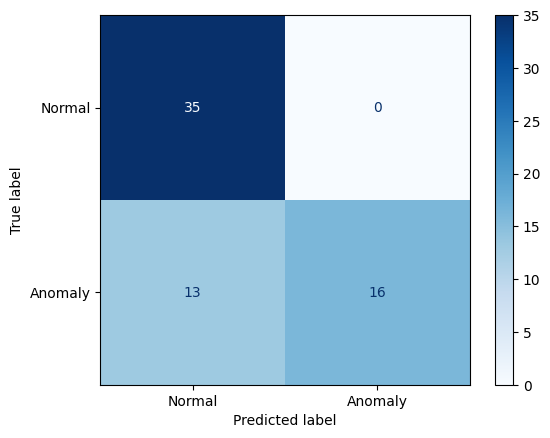

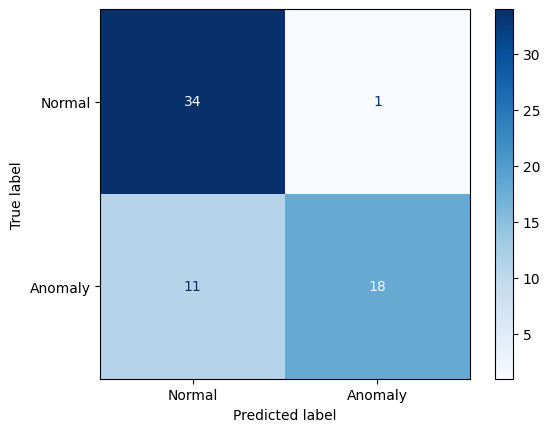

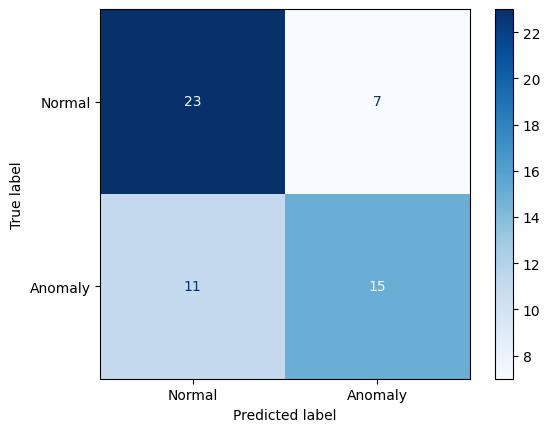

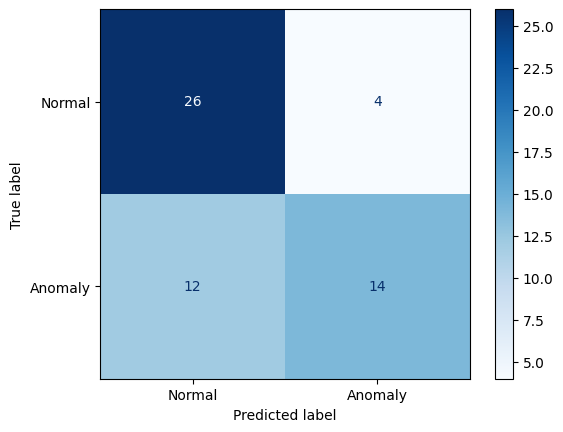

In [6]:
for manufacturer in results.keys():
    print(f'Manufacturer m{manufacturer}')
    for config_name in results[manufacturer].keys():
        print(f'Model {config_name}:')

        reliability = fbeta_score(
            true_anomalies[manufacturer], predicted_anomalies[manufacturer][config_name],
            beta=0.5
        )
        precision = precision_score(
            true_anomalies[manufacturer], predicted_anomalies[manufacturer][config_name]
        )
        recall = recall_score(
            true_anomalies[manufacturer], predicted_anomalies[manufacturer][config_name]
        )
        print(f'Reliability: {reliability:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

        disp = ConfusionMatrixDisplay.from_predictions(
            y_true=true_anomalies[manufacturer], y_pred=predicted_anomalies[manufacturer][config_name],
            cmap='Blues',
            labels=[False, True],
            display_labels=['Normal', 'Anomaly'],
        )


### Visualise results

In [7]:
manufacturer = 1
config_name = 'cond_ae'
event_id = 49
report_date = dataset.events[manufacturer].loc[event_id]['Report date']

# Event details
dataset.events[manufacturer].loc[event_id]

substation ID                                                            18
Report date                                             2019-05-04 07:19:00
Problem EN                                                           no DHW
Event description EN      The DHW controller was set to night mode. Rese...
Possible anomaly start                                  2019-05-03 11:00:00
Possible anomaly end                                    2019-05-05 07:19:00
Training start                                          2016-12-16 10:00:00
Training end                                            2019-04-20 07:19:00
efd_possible                                                           True
Fault label                        Control unit: Incorrect parameterisation
Monitoring potential                                                      4
Event type                                                          anomaly
Event end                                               2019-05-04 07:19:00
Event start 

#### Criticality

Text(0.5, 0, '')

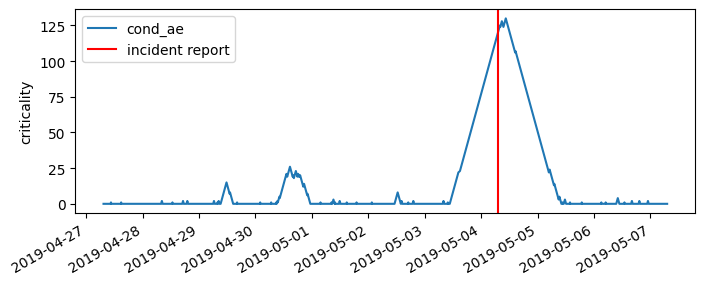

In [8]:
predictions = results[manufacturer][config_name][event_id]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
crit = predictions.criticality()
crit.plot(ax=ax, label=config_name)

ax.axvline(report_date, label='incident report', c='r', linestyle='-')

ax.legend(loc='upper left')
ax.set_ylabel('criticality')
ax.set_xlabel('')

#### ARCANA results

In [9]:
test_data = dataset.get_event_data(manufacturer, event_id)['test_data']

# find longest detected anomaly event (continuous run of predicted anomalous timestamps)
anomaly_events, _ = create_events(
    test_data,
    predictions.predicted_anomalies,
    min_event_length=12
)
longest_anomaly_event = anomaly_events[anomaly_events['duration'] == anomaly_events['duration'].max()].iloc[0]

# Calculate ARCANA feature importances
top_features = get_arcana_importances(manufacturer, event_id, config_name, test_data.loc[longest_anomaly_event['start']:report_date])

top_features

s_dhw_supply_temperature_setpoint    0.405723
p_net_meter_flow                     0.099440
p_net_return_temperature             0.092462
p_hc1_return_temperature             0.075755
p_net_meter_heat_power               0.074011
s_dhw_lower_storage_temperature      0.073638
s_dhw_upper_storage_temperature      0.058171
p_net_supply_temperature             0.039459
outdoor_temperature                  0.034128
s_dhw_supply_temperature             0.028003
s_hc1_supply_temperature             0.010396
s_hc1_supply_temperature_setpoint    0.008813
dtype: float32

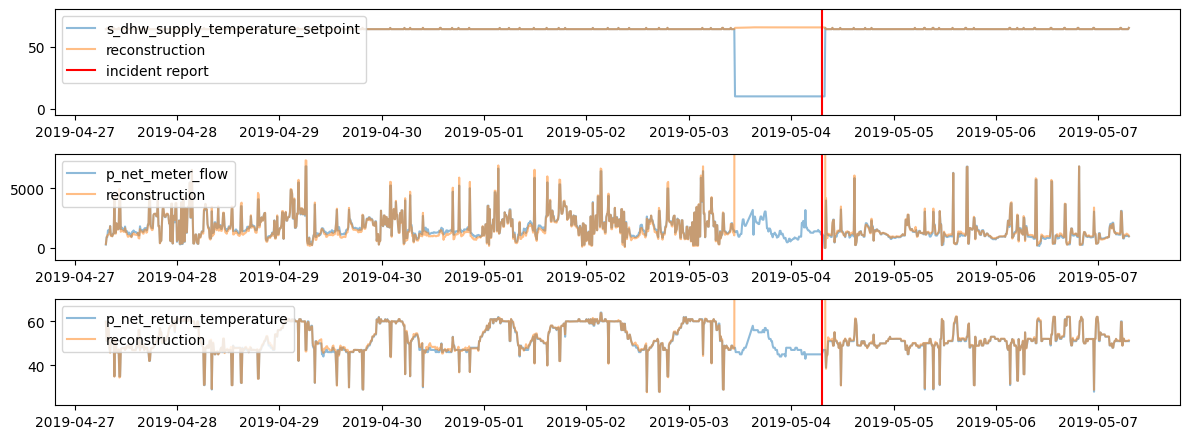

In [10]:
# Plot the reconstruction of the top 3
fig, ax = plot_reconstruction(test_data, predictions.reconstruction, top_features.index[:3].to_list())

for ax_ in ax:
    ax_.axvline(report_date, label='incident report', color='r', linestyle='-')

ax[0].legend(loc='upper left')